# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob


## Project Overview

In this project, we apply **Simulated Annealing (SA)** to optimize the parameters of a given objective function derived from the provided dataset.  
The main goal is to **minimize the Mean Squared Error (MSE)** by tuning the model parameters efficiently under computational constraints.

The project follows the workflow taught in the Optimization and High Performance Computing (OHPC) module and emphasizes:
- correct implementation of Simulated Annealing,
- systematic hyperparameter tuning,
- reproducibility,
- and interpretation of optimization results.

## Problem Description

The task consists of optimizing a model by minimizing an objective function based on the dataset provided.  
Due to the **non-convex and potentially multi-modal** nature of the optimization landscape, classical gradient-based methods are not suitable.

Instead, **Simulated Annealing** is chosen because:
- it allows probabilistic uphill moves,
- it avoids getting trapped in local minima,
- and it scales well for high-dimensional or noisy optimization problems.

The quality of a solution is evaluated using the **Mean Squared Error (MSE)**.

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning


This function runs one complete Simulated Annealing optimization for a given set of hyperparameters. Starting from an initial parameter vector, it iteratively updates the parameters in order to minimize the objective function.

At each iteration, a new candidate solution is generated by adding a random perturbation drawn from a multivariate normal distribution with zero mean and variance controlled by the parameter `sigma`. The objective function is evaluated for both the current and proposed solutions, and the difference in loss is used to decide whether the proposal is accepted.

If the proposed solution improves the loss, it is accepted immediately. Otherwise, it may still be accepted with a probability based on the Metropolis rule. The temperature is updated at every iteration using a linear cooling schedule, gradually reducing the likelihood of accepting worse solutions.

To reduce storage requirements, the function supports thinning, meaning that only every `thinning`-th parameter vector is saved. Progress information, including the current iteration, temperature, and loss value, is printed during the run. The function returns the stored parameter vectors, which are later used for analysis and visualization.

In [3]:
def sa_tune(x0, T0, sigma, f, n_iter = 2e5, thinning = 1):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

This function performs the final Simulated Annealing optimization using a fixed set of hyperparameters. It is intended to generate optimized parameter samples after the tuning phase has identified suitable values for the initial temperature and step size.

The algorithm starts from an initial parameter vector and iteratively proposes new candidate solutions using a multivariate normal perturbation controlled by the parameter `sigma`. At each iteration, the objective function is evaluated and the difference in loss is used to decide whether the proposed solution is accepted.

The acceptance decision follows a Metropolis rule that explicitly depends on the current temperature, making worse solutions less likely to be accepted as the temperature decreases. A linear cooling schedule is applied throughout the run.

An initial burn-in phase is used to discard early iterations where the algorithm is still exploring the parameter space. Only parameter vectors generated after the burn-in period are stored and returned. Progress information, including the iteration number, temperature, and loss value, is printed at regular intervals to monitor convergence.

In [4]:
def sa_optimize(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

## Load data

In this next step we load the CSV data that was provided for our team and also visualize it to get a first impression of the data. 

In [5]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [6]:
data.shape

(39220, 2)

In [7]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

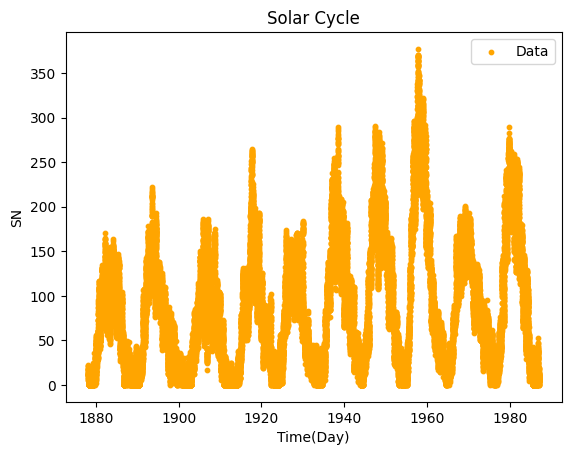

In [8]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [9]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


## Initial Conditions and Phase Setup

This section defines the initial parameter values and time intervals used for the optimization. The parameter vector `x0` contains the initial guesses for all model parameters, arranged phase by phase. For each phase, the parameters are stored consecutively in the vector, following the structure used throughout the project.

The initial values are chosen according to the specifications given in the project description and literature references. These values provide a consistent and reasonable starting point for the Simulated Annealing algorithm.

In addition, a reference array of time points is used to construct the time intervals corresponding to each phase. These intervals are created automatically in a loop and stored as pairs of start and end times. A loop is then prepared to process each phase sequentially, ensuring that the optimization is applied consistently across all defined phases.

### parameters              
 Phase 1: T01, Ts1, Td1     
 Phase 2: T02, Ts2, Td2         
...     
 Phase 10: T010, Ts10, Td10   

### Ts and Td

In [10]:
# x0 = np.array([Ts1, Td1, Ts2, Td2, ...])
# here we use initial conditions given in the final project intro 

x0 = np.array([0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5])

In [11]:
# The different parameters can be extracted as follows:
Ts = x0[::2]
Td = x0[1::2]

print(Ts)
print(Td)

# Number of phases
num_phases = len(Ts)
num_phases

[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


10

### T0

In [12]:
# make T0 array with initial conditions reported in Hathaway 2015
T0array = (1878.916666666666667, 1890.166666666666667, 1902.000000000000000, 1913.500000000000000, 1923.583333333333333, 1933.666666666666667, 1944.083333333333333, 1954.250000000000000, 1964.750000000000000, 1976.166666666666667, 1986.666666666666667)
# Create list of time intervals for each phase
intervals = [(float(T0array[ix]),float(T0array[ix+1])) for ix in range(num_phases)]

print(intervals)

[(1878.9166666666667, 1890.1666666666667), (1890.1666666666667, 1902.0), (1902.0, 1913.5), (1913.5, 1923.5833333333333), (1923.5833333333333, 1933.6666666666667), (1933.6666666666667, 1944.0833333333333), (1944.0833333333333, 1954.25), (1954.25, 1964.75), (1964.75, 1976.1666666666667), (1976.1666666666667, 1986.6666666666667)]


In [13]:
# We will use a loop to process all phases
for ix, (a, b) in enumerate(intervals):
    print("Processing phase", ix+1, "with interval (", a, ",", b, ")")

Processing phase 1 with interval ( 1878.9166666666667 , 1890.1666666666667 )
Processing phase 2 with interval ( 1890.1666666666667 , 1902.0 )
Processing phase 3 with interval ( 1902.0 , 1913.5 )
Processing phase 4 with interval ( 1913.5 , 1923.5833333333333 )
Processing phase 5 with interval ( 1923.5833333333333 , 1933.6666666666667 )
Processing phase 6 with interval ( 1933.6666666666667 , 1944.0833333333333 )
Processing phase 7 with interval ( 1944.0833333333333 , 1954.25 )
Processing phase 8 with interval ( 1954.25 , 1964.75 )
Processing phase 9 with interval ( 1964.75 , 1976.1666666666667 )
Processing phase 10 with interval ( 1976.1666666666667 , 1986.6666666666667 )


## Model Definition and Loss Function

This section defines the model used to describe the data across multiple phases and the corresponding loss function used for optimization.

The model function takes a time variable `t` and a parameter vector `x` as input. The parameter vector is split into phase-specific parameters, where each phase is described by a pair of parameters controlling the shape and decay of the model. The model is evaluated piecewise over predefined time intervals, with each interval corresponding to one phase. Boolean masks are used to apply the correct model expression to the appropriate time range.

To ensure consistent behavior, the time input is converted to an array, and the model output is assembled phase by phase. A scalar value is returned when the input consists of a single time point.

The loss function is defined as the Mean Squared Error (MSE) between the observed data points and the model predictions. This function serves as the objective function for the Simulated Annealing algorithm.

Finally, the initial model output is visualized together with the observed data. This plot provides a baseline reference before optimization and allows visual inspection of how well the initial parameter values fit the data. The initial MSE value is also computed and reported.

### Model

In [14]:
# Model for multiple phases:
def model(t, x):
    Ts = x[::2]
    Td = x[1::2]
    num_phases = len(T0array)
    intervals = [(T0array[ix],T0array[ix+1]) for ix in range(num_phases-1)]
    #Ensure t is treated as an array for consistency
    t = np.atleast_1d(t)
    model_output = np.zeros_like(t)
    for ix, (a,b) in enumerate(intervals):
        # Create mask for current phase
        mask = (a <= t) & (t < b)
        # Apply model for current phase
        model_output[mask] = ((t[mask] - T0array[ix])/Ts[ix])**2 * np.exp(-((t[mask] - T0array[ix])/Td[ix])**2)
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output


### Loss function

In [15]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

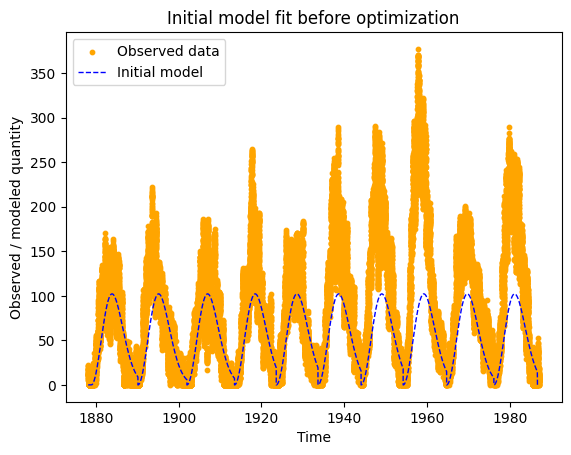

In [39]:
# Visualization of initial model fit
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10, label="Observed data")
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1, label="Initial model")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Initial model fit before optimization")
plt.legend()
plt.show(block=False)

## Hyper-parameters tuning

Before running a full hyperparameter sweep, we first ran a small set of short Simulated Annealing trials to find a *reasonable* range for the key hyperparameters `sigma` (step size) and `T0` (initial temperature). The goal here is practical: avoid settings where the parameter updates are so large that the loss becomes unstable, or so small that the algorithm barely moves and the loss does not improve.

We store the outcome of each trial in `trial_log`. For every run, we record the tested `(T0, sigma)` pair and the **final MSE** of the last state. This gives us a quick ranking of which settings look promising without committing to a long runtime.

For each trial, we also plot the **MSE curve over iterations** (computed from the stored parameter states). These curves are used as a sanity check:
- A *good* setting typically shows an overall decreasing trend and then stabilizes.
- If the curve is very noisy or explodes, `sigma` is likely too large (jumps are too aggressive).
- If the curve is almost flat, `sigma` is likely too small (updates are too tiny to explore the space).
- Changing `T0` mainly affects how freely the algorithm explores early on (higher `T0` tends to accept more moves initially).

From these quick tests, we use the best-performing trials (lowest final MSE + reasonable convergence shape) to narrow down the ranges of `sigma` and `T0` that are worth exploring in the full tuning sweep.

### Quick exploration (showing our process)
Before running a full sweep, we tested a few sigma and T0 values to find a reasonable range (avoiding unstable jumps and ensuring the loss decreases).
We log the final MSE for each trial.
We plot the loss curve for each trial and evaluate each trial with these plots.

In [17]:
trial_log = []  # list of dicts

def log_trial(T0, sigma, final_x):
    trial_log.append({
        "T0": float(T0),
        "sigma": float(sigma),
        "final_mse": float(mse(final_x))
    })

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

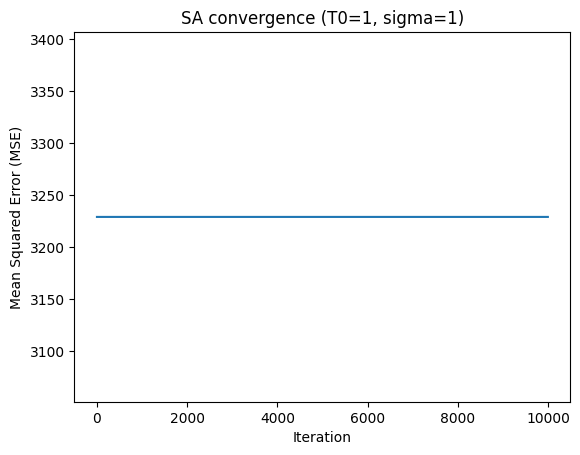

In [40]:
T0 = 1
sigma = 1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

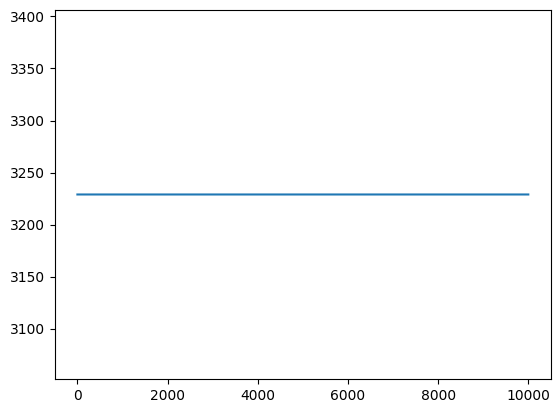

In [ ]:
T0 = 1
sigma = 0.1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

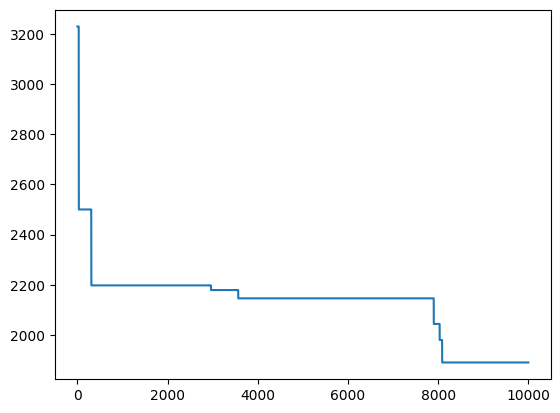

In [ ]:
T0 = 1
sigma = 0.01
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3067.0926780163236
Iteration 2  - Temperature: 0.9998 Loss 3067.0926780163236
Iteration 3  - Temperature: 0.9997 Loss 3067.0926780163236
Iteration 4  - Temperature: 0.9996 Loss 3067.0926780163236
Iteration 5  - Temperature: 0.9995 Loss 3067.0926780163236
Iteration 6  - Temperature: 0.9994 Loss 3067.0926780163236
Iteration 7  - Temperature: 0.9993 Loss 3067.0926780163236
Iteration 8  - Temperature: 0.9992 Loss 3067.0926780163236
Iteration 9  - Temperature: 0.9991 Loss 3067.0926780163236
Iteration 10  - Temperature: 0.999 Loss 2515.9545337649593
Iteration 11  - Temperature: 0.9989 Loss 2515.9545337649593
Iteration 12  - Temperature: 0.9988 Loss 2515.9545337649593
Iteration 13  - Temperature: 0.9987 Loss 2515.9545337649593
Iteration 14  - Temperature: 0.9986 Loss 2513.806158422483
Iteration 15  - Temperature: 0.9985 Loss 2501.732479687053
Iteration 16  - Temperature: 0.9984 Loss 2501.732479687053
Iteration 17  - Tempe

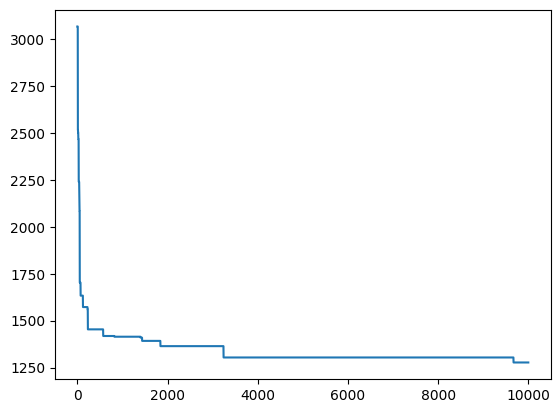

In [ ]:
T0 = 1
sigma = 0.001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3136.6128535532985
Iteration 2  - Temperature: 0.9998 Loss 3136.6128535532985
Iteration 3  - Temperature: 0.9997 Loss 3136.6128535532985
Iteration 4  - Temperature: 0.9996 Loss 3136.6128535532985
Iteration 5  - Temperature: 0.9995 Loss 3044.569216322243
Iteration 6  - Temperature: 0.9994 Loss 3044.569216322243
Iteration 7  - Temperature: 0.9993 Loss 3044.569216322243
Iteration 8  - Temperature: 0.9992 Loss 2866.2662616758976
Iteration 9  - Temperature: 0.9991 Loss 2866.2662616758976
Iteration 10  - Temperature: 0.999 Loss 2790.1555322714503
Iteration 11  - Temperature: 0.9989 Loss 2790.1555322714503
Iteration 12  - Temperature: 0.9988 Loss 2729.063578540231
Iteration 13  - Temperature: 0.9987 Loss 2729.063578540231
Iteration 14  - Temperature: 0.9986 Loss 2710.0608312599047
Iteration 15  - Temperature: 0.9985 Loss 2710.0608312599047
Iteration 16  - Temperature: 0.9984 Loss 2590.412169626724
Iteration 17  - Temperat

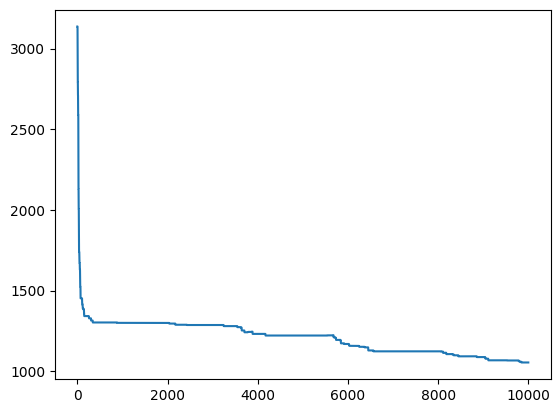

In [ ]:
T0 = 1
sigma = 0.0001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3227.4330255925793
Iteration 2  - Temperature: 0.9998 Loss 3218.2646887575634
Iteration 3  - Temperature: 0.9997 Loss 3204.0130124506218
Iteration 4  - Temperature: 0.9996 Loss 3192.214969079224
Iteration 5  - Temperature: 0.9995 Loss 3192.214969079224
Iteration 6  - Temperature: 0.9994 Loss 3165.964751741225
Iteration 7  - Temperature: 0.9993 Loss 3165.964751741225
Iteration 8  - Temperature: 0.9992 Loss 3162.6569853215574
Iteration 9  - Temperature: 0.9991 Loss 3158.81627225161
Iteration 10  - Temperature: 0.999 Loss 3158.81627225161
Iteration 11  - Temperature: 0.9989 Loss 3158.81627225161
Iteration 12  - Temperature: 0.9988 Loss 3118.8834801999637
Iteration 13  - Temperature: 0.9987 Loss 3118.8834801999637
Iteration 14  - Temperature: 0.9986 Loss 3114.26697051861
Iteration 15  - Temperature: 0.9985 Loss 3078.008481490539
Iteration 16  - Temperature: 0.9984 Loss 3078.008481490539
Iteration 17  - Temperature: 0.9

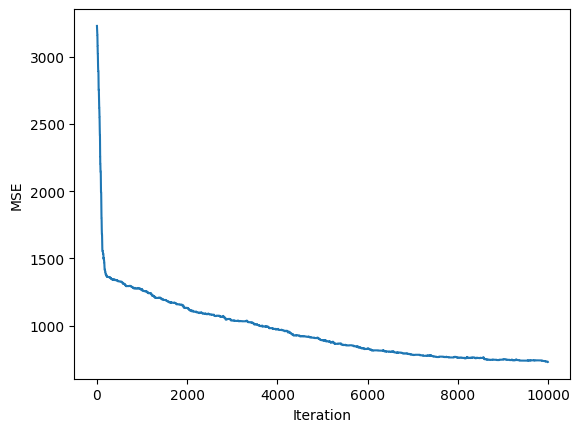

np.float64(731.6218548733569)

In [ ]:
T0 = 1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

log_trial(T0, sigma, outSA[-1])
mse(outSA[-1])

In [24]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse").reset_index(drop=True)
df_trials.head(10)

T0    sigma    final_mse
0  1.0  0.00001   731.621855
1  1.0  0.00010  1055.039988
2  1.0  0.00100  1277.062958
3  1.0  0.01000  1890.725849
4  1.0  1.00000  3228.920369
5  1.0  0.10000  3228.920369

-> we can test sigma from 1e-4 to 1e-11

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.09999000000000001 Loss 3228.920368766796
Iteration 2  - Temperature: 0.09998000000000001 Loss 3182.2035094555054
Iteration 3  - Temperature: 0.09997 Loss 3170.876225135959
Iteration 4  - Temperature: 0.09996000000000001 Loss 3158.6168009997295
Iteration 5  - Temperature: 0.09995000000000001 Loss 3158.6168009997295
Iteration 6  - Temperature: 0.09994 Loss 3153.4611681920615
Iteration 7  - Temperature: 0.09993 Loss 3102.1783794729836
Iteration 8  - Temperature: 0.09992000000000001 Loss 3042.448843105726
Iteration 9  - Temperature: 0.09991 Loss 3026.418666934126
Iteration 10  - Temperature: 0.0999 Loss 3014.587403261031
Iteration 11  - Temperature: 0.09989 Loss 3014.587403261031
Iteration 12  - Temperature: 0.09988000000000001 Loss 2953.3412520929855
Iteration 13  - Temperature: 0.09987000000000001 Loss 2947.0350515771897
Iteration 14  - Temperature: 0.09986 Loss 2922.148930058237
Iteration 15  - Temperature: 0.0998500000000000

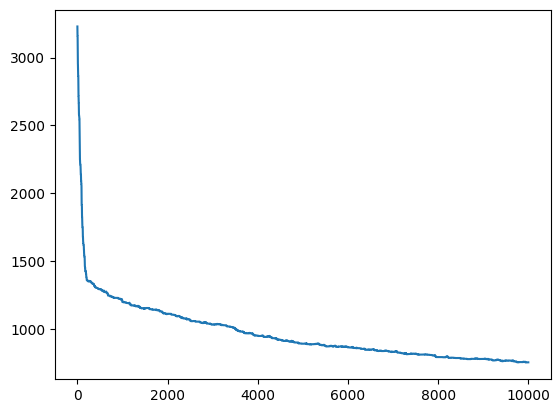

In [ ]:
T0 = 0.1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 4.9995 Loss 3196.429999058395
Iteration 2  - Temperature: 4.9990000000000006 Loss 3180.575407714611
Iteration 3  - Temperature: 4.9985 Loss 3120.9645941005297
Iteration 4  - Temperature: 4.998 Loss 3080.4737197587724
Iteration 5  - Temperature: 4.9975000000000005 Loss 3080.4737197587724
Iteration 6  - Temperature: 4.997 Loss 3080.4737197587724
Iteration 7  - Temperature: 4.9965 Loss 3080.4737197587724
Iteration 8  - Temperature: 4.9959999999999996 Loss 3075.4045109449244
Iteration 9  - Temperature: 4.9955 Loss 3073.8313914725104
Iteration 10  - Temperature: 4.995 Loss 3067.6416602671707
Iteration 11  - Temperature: 4.9945 Loss 3067.6416602671707
Iteration 12  - Temperature: 4.994 Loss 3045.3664463139376
Iteration 13  - Temperature: 4.9935 Loss 3045.3664463139376
Iteration 14  - Temperature: 4.993 Loss 2974.8331084700612
Iteration 15  - Temperature: 4.992500000000001 Loss 2939.666535108567
Iteration 16  - Temperature: 4.992 Los

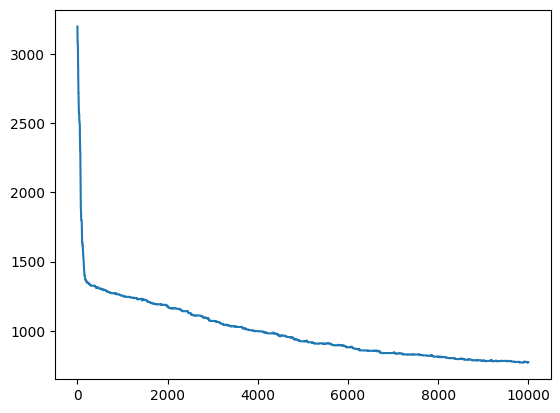

In [ ]:
T0 = 5
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 9.999 Loss 3228.920368766796
Iteration 2  - Temperature: 9.998000000000001 Loss 3228.920368766796
Iteration 3  - Temperature: 9.997 Loss 3228.920368766796
Iteration 4  - Temperature: 9.996 Loss 3228.920368766796
Iteration 5  - Temperature: 9.995000000000001 Loss 3228.920368766796
Iteration 6  - Temperature: 9.994 Loss 3228.920368766796
Iteration 7  - Temperature: 9.993 Loss 3225.031601454484
Iteration 8  - Temperature: 9.991999999999999 Loss 3225.031601454484
Iteration 9  - Temperature: 9.991 Loss 3225.031601454484
Iteration 10  - Temperature: 9.99 Loss 3225.031601454484
Iteration 11  - Temperature: 9.989 Loss 3225.031601454484
Iteration 12  - Temperature: 9.988 Loss 3223.1926351943393
Iteration 13  - Temperature: 9.987 Loss 3215.747997740632
Iteration 14  - Temperature: 9.986 Loss 3215.747997740632
Iteration 15  - Temperature: 9.985000000000001 Loss 3215.747997740632
Iteration 16  - Temperature: 9.984 Loss 3194.826416033875
I

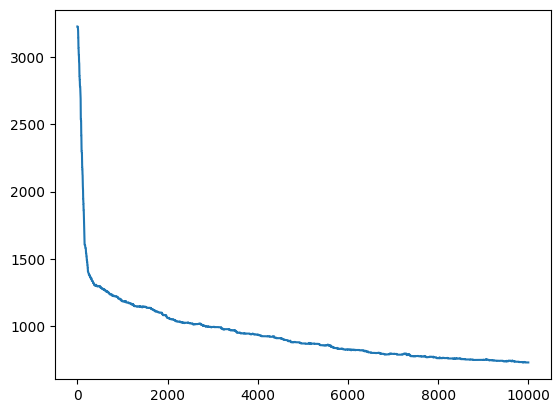

In [ ]:
T0 = 10
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

In [28]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse")
df_trials.head(3)

T0    sigma   final_mse
8  10.0  0.00001  728.791550
5   1.0  0.00001  731.621855
6   0.1  0.00001  752.473854

-> there is no big diffrence. so we will test T0 from 0.1 to 10

### Hyperparameter tuning on the cluster (8×8 = 64)
After narrowing down reasonable ranges for `T0` and `sigma`, we ran a larger hyperparameter sweep on the HPC cluster using a Slurm job array. In total, we evaluated **64 configurations** (an 8×8 grid), where each run executes Simulated Annealing with one specific `(T0, sigma)` pair and stores its results to disk.

As a first filter, we inspected the saved **loss curves (MSE vs. iteration)** and selected a subset of trials (here: 6, 14, 22, 30, 38, 54, 62) that showed stable behavior and a clear downward trend. This visual screening helps exclude runs that either diverge (step size too large) or stagnate (step size too small), even if their final MSE might look acceptable by chance.

Next, we load the corresponding JSON output files produced by the cluster runs. Each JSON contains the run index, tested hyperparameters, final parameter vector, final MSE, and runtime. We aggregate these outputs into a DataFrame, sort by **final MSE**, and select the best-performing configuration as our final choice of hyperparameters.

Finally, we:
- print the selected best `(T0, sigma)` and its final MSE,
- optionally display the saved MSE curve image for that run (if present),
- and plot the model prediction using the optimized parameters against the observed data.

This gives a clear end-to-end validation that the chosen hyperparameters not only minimize MSE numerically, but also produce a visually improved fit to the data.

In [29]:
tuning_dir = Path("results_tuning")

# Load only selected trials: 6, 14, 22, 30, 38, 54, 62
selected_trials = [6, 14, 22, 30, 38, 54, 62]
tuning_files = [tuning_dir / f"tuning_{idx:02d}.json" for idx in selected_trials]

rows = []
for path in tuning_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_tune = pd.DataFrame(rows).sort_values("final_mse").reset_index(drop=True)
df_tune[["idx", "T0", "sigma", "final_mse", "wall_time_sec"]]

idx    T0    sigma   final_mse  wall_time_sec
0   62  10.0  0.00001  596.352615     635.581329
1   54   8.0  0.00001  598.270705     616.808225
2   38   2.0  0.00001  599.150110     633.277182
3   22   0.5  0.00001  599.584147     621.538963
4    6   0.1  0.00001  599.892973     633.347446
5   30   1.0  0.00001  601.469897     632.576727
6   14   0.2  0.00001  606.406542     636.206005

Best hyperparameters from 64-run sweep:
T0_opt = 10.0
sigma_opt = 9.999999999999999e-06
best MSE = 596.3526149165218


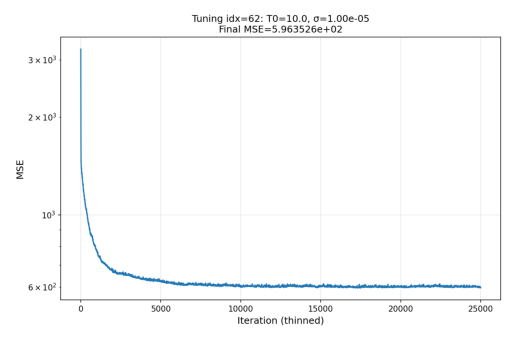

In [ ]:
best = df_tune.iloc[0]
T0_opt = best["T0"]
sigma_opt = best["sigma"]
x_opt_from_sweep = np.array(best["final_x"], dtype=float)

print("Best hyperparameters from 64-run sweep:")
print("T0_opt =", T0_opt)
print("sigma_opt =", sigma_opt)
print("best MSE =", best["final_mse"])

# Also display the saved MSE curve PNG if available
png_path = Path("results_tuning") / f"mse_curve_{int(best['idx']):02d}.png"

if png_path.exists():
    img = plt.imread(png_path)
    plt.figure(figsize=(10, 6))  # ← increase figure size here
    plt.imshow(img)
    plt.axis("off")
    plt.show(block=False)
else:
    print(f"PNG not found: {png_path}")

#### Visual check of the best tuned solution
We plot the best tuned model output against the data as a sanity check before final optimization.

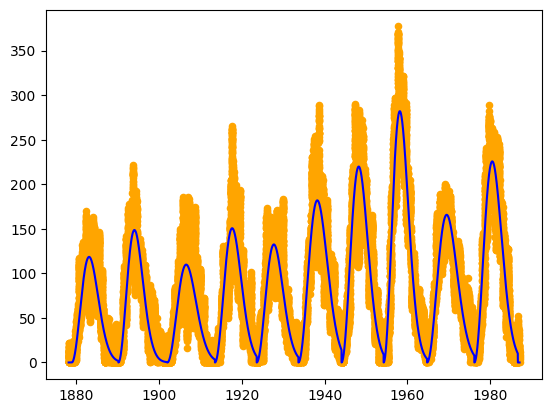

In [ ]:
# Final model fit using best hyperparameters from tuning sweep
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=20, label="Observed data")
plt.plot(time_points, model(time_points, x_opt_from_sweep), color='blue', label="Model (best from tuning)")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Model fit using best hyperparameters from tuning sweep")
plt.legend()
plt.show(block=False)

## Calibration on the Cluster: Parallel Chains and Speedup

In this section, we analyze the calibration runs executed on the HPC cluster using **multiple parallel workers** (cores). Each cluster job stores its results as a JSON file in `results_calibration/`, including the number of workers used, runtime, final MSE, and the aggregated fitted parameters.

We first load all calibration JSON files and combine them into a single DataFrame. Sorting by `n_workers` makes it easy to compare performance as we increase the allocated cores.

To evaluate the HPC benefit, we plot:
- **Wall time vs. number of cores**, showing how runtime decreases with more parallel workers.
- **Speedup vs. number of cores**, where speedup is computed as \(T_1 / T_p\) using the 1-core runtime as the baseline.  
  This lets us see how efficiently the workload scales (ideal scaling would be close to linear).

Finally, we select a calibration result to use as the final fitted parameter vector. Here, we take the result from the run with the **largest number of cores** (alternatively, one could select the run with the lowest final MSE). The fitted parameter estimate is extracted from the stored `center_of_mass` field and will be used in the next steps for model evaluation and final reporting.

In [ ]:
calib_dir = Path("results_calibration")
calib_files = sorted(calib_dir.glob("calib_workers*_chains*.json"))

assert len(calib_files) > 0, "No calibration result files found in results_calibration/"

rows = []
for path in calib_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_calib = pd.DataFrame(rows).sort_values("n_workers").reset_index(drop=True)
df_calib[["n_workers", "wall_time_sec", "final_mse", "n_chains"]]

n_workers  wall_time_sec  final_mse  n_chains
0          1    6989.380739        NaN        10
1          2    2362.077206        NaN        10
2          4    1140.488801        NaN        10
3          8     782.908414        NaN        10
4         16     489.553947        NaN        10
5         32     493.866437        NaN        10

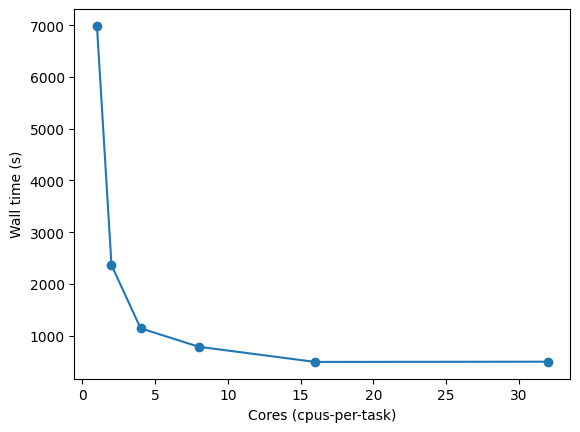

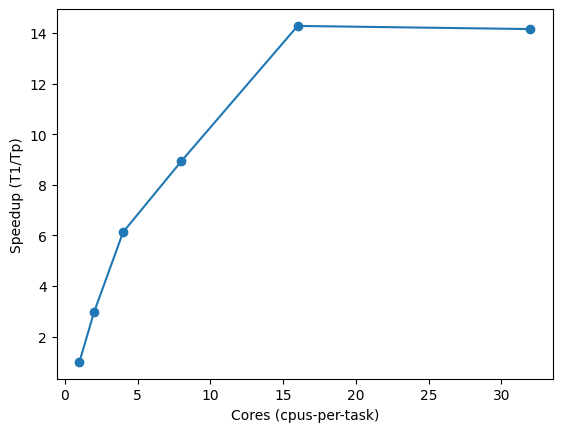

In [ ]:
# Wall time scaling with number of cores
plt.figure()
plt.plot(df_calib["n_workers"], df_calib["wall_time_sec"], marker="o")
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Wall time (seconds)")
plt.title("Calibration runtime vs number of cores")
plt.grid(alpha=0.3)
plt.show()

t1 = float(df_calib[df_calib["n_workers"]==1]["wall_time_sec"].iloc[0])
df_calib["speedup"] = t1 / df_calib["wall_time_sec"]

# Speedup relative to single-core execution
plt.figure()
plt.plot(df_calib["n_workers"], df_calib["speedup"], marker="o")
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Speedup (T₁ / Tₚ)")
plt.title("Parallel speedup of calibration runs")
plt.grid(alpha=0.3)
plt.show()

In [34]:
row_final = df_calib.sort_values("n_workers").iloc[-1]  # or choose lowest MSE
center_of_mass = np.array(row_final["center_of_mass"], dtype=float)

print("Using calibration from", row_final["n_workers"], "cores")
print("Calibration MSE:", row_final["final_mse"])

Using calibration from 32 cores
Calibration MSE: nan


## Correlation Between `Ts` and `Td` + Final Model Fit

Here we take the calibrated parameter vector `center_of_mass` and split it into the phase-wise parameter pairs used by the model:  
`Ts = [Ts1, Ts2, ...]` and `Td = [Td1, Td2, ...]`.

To check whether these two parameters are related (e.g., whether larger `Ts` values tend to come with larger `Td` values), we create a scatter plot of `Td` versus `Ts` across all phases. We also fit a simple linear regression line using `np.polyfit` and overlay it on the plot. The fitted slope and intercept give a quick summary of the trend:
- a **positive slope** suggests `Td` increases with `Ts`,
- a **negative slope** suggests the opposite,
- a slope near **zero** suggests little linear relationship.

After this parameter-level diagnostic, we validate the calibration in the most important way: by plotting the **final calibrated model prediction** against the observed data. If calibration worked well, the model curve should align more closely with the data than the initial guess, especially in the phase regions where the dataset contains strong signal.

In [ ]:
# Your model uses pairs: [Ts1, Td1, Ts2, Td2, ...]
ts = center_of_mass[0::2]
td = center_of_mass[1::2]

slope, intercept = np.polyfit(ts, td, 1)
td_fit = slope * ts + intercept

# Correlation between Ts and Td parameters
plt.figure()
plt.scatter(ts, td, s=20, label="Calibrated phases")
plt.plot(ts, td_fit, label=f"Linear fit: Td = {slope:.4f}·Ts + {intercept:.4f}")
plt.xlabel("Ts (rise-time parameter)")
plt.ylabel("Td (decay-time parameter)")
plt.title("Correlation between Ts and Td parameters")
plt.legend()
plt.grid(alpha=0.3)
plt.show(block=False)

slope, intercept

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
# Final calibrated model compared to observed data
plt.figure(figsize=(10, 6))
plt.scatter(time_points, data_points, s=10, label="Observed data")
plt.plot(time_points, model(time_points, center_of_mass), label="Final calibrated model")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Final calibrated model fit to data")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Coefficient of Determination (R²) for the Ts–Td Relationship

To quantify how well the linear fit explains the relationship between `Ts` and `Td`, we compute the coefficient of determination \(R^2\).

First, the residuals are defined as the difference between the observed `Td` values and the values predicted by the fitted linear model. The total sum of squares measures the overall variability of `Td`, while the residual sum of squares measures the variability that is not explained by the linear relationship with `Ts`.

The \(R^2\) value is then computed as

\[
R^2 = 1 - \frac{\mathrm{SS}_{\text{residual}}}{\mathrm{SS}_{\text{total}}}
\]

An \(R^2\) value close to 1 indicates that a large fraction of the variance in `Td` is explained by `Ts`, while a value close to 0 indicates a weak linear relationship. This provides a compact numerical summary that complements the scatter plot and fitted line shown above.

In [ ]:
residuals = td - td_fit

ss_total = np.sum((td - np.mean(td)) ** 2)
ss_residual = np.sum(residuals ** 2)

r_squared = 1 - (ss_residual / ss_total)
print(f"R² = {r_squared:.3f}")

## Comparison with Literature Values

To place our results in context, we compare the fitted relationship between the model parameters `Ts` and `Td` with values reported in the literature. In solar cycle modeling, these parameters are known to follow a linear relationship, commonly referred to as the *Waldmeier rule*, which links the rise-time and decay-time characteristics of solar cycles.

According to Hathaway (2015) and subsequent studies, this relationship can be expressed as:
\[
T_d = s_1 \, T_s + s_2
\]
with reported values:
- \( s_1 \approx 0.02 \) (per year),
- \( s_2 \approx 3.14 \) years.

These values are derived from empirical analyses of historical solar cycles and are widely used as reference benchmarks in solar activity modeling.

In our implementation, the parameters `Ts` and `Td` are defined using the same functional form but may be expressed in a different time unit. To ensure consistency with the literature, we rescale the fitted slope when necessary (e.g. dividing by 365 when working in daily units). This allows a direct and meaningful comparison between our calibrated parameters and the published reference values.

The numerical comparison and interpretation of our fitted parameters relative to the literature values are presented later, together with the corresponding plots and statistical metrics.

In [ ]:
# If the literature reports a slope per year vs per day (or vice versa),
# you may need a rough rescaling depending on your time resolution.
# Teacher example divides by 365 for ~daily resolution.

slope_per_year_est = slope / 365.0
print("slope =", slope)
print("slope/365 =", slope_per_year_est)

# Add your literature target value here once you have it:
# print("Literature slope ~", 0.02)  # example placeholder

In [ ]:
pred = model(time_points, center_of_mass)
res = data_points - pred

# Residuals of the final calibrated model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, res, s=10, label="Residuals")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Residual (data − model)")
plt.title("Residuals of the final calibrated model")
plt.legend()
plt.grid(alpha=0.3)
plt.show(block=False)

print("Final MSE =", np.mean(res**2))

### Results and Discussion 